In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

## QC pills box detection 

    This notebook is a work for pill box dent detection using edge detection and hough transform. Combinded with finding curves on the edges lines in picture to check if the box is in good shape.

In [10]:
def load_images_from_directory(directory):
    path = Path(directory)
    path = path.glob("*.png")

    images = []
    # Iterate over all files with .png extension in the directory
    for imagepath in path:
        img = cv2.imread(str(imagepath))  # Read image from file
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
        images.append(img)


    return images

directory1 = ".dataset/damaged/side" # Path to the directory containing the images


images1 = load_images_from_directory(directory1)
print(len(images1), "images in the first test set")

100 images in the first test set


In [11]:
def edge_detection(image, sigma=0.33):
    # Convert the image to grayscale
    v = np.median(image)
    lower = int(max(100, (1.0 - sigma) * v))
    upper = int(min(130, (1.0 + sigma) * v))

    # Apply edge detection
    edges = cv2.Canny(image, lower, upper)
    return edges

In [12]:
def find_hough_lines(edges, 
                     rho=0.77, # distance resolution in pixels of the Hough grid
                     theta=(np.pi/180), # angular resolution in radians of the Hough grid
                     threshold=70, # minimum number of votes (intersections in Hough grid cell)
                     min_line_length=70, # minimum number of pixels making up a line
                     max_line_gap=5): # maximum gap in pixels between connectable line segments
    return cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

In [13]:
def draw_hough_lines(img, lines):
    res = img.copy()
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(res, (x1, y1), (x2, y2), 40, thickness=3)
    return res

In [14]:
#find if there is a curve edges on the image
def find_curved_edges(lines, min_angle=60, max_angle=120):
    # Iterate over the output "lines" and draw them on the image
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if min_angle <= abs(angle) <= max_angle:
                return True
    return False


In [15]:
def predict_damage(images):
    damage = 0
    for image in images:
        edges = edge_detection(image)
        lines = find_hough_lines(edges)
        if find_curved_edges(lines):
            damage += 1
    return damage / len(images)

Process Demonstration

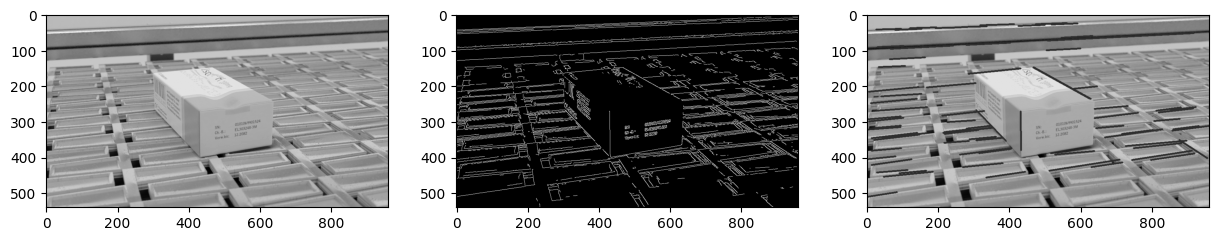

In [16]:
img = images1[0]
edges = edge_detection(img)
lines = find_hough_lines(edges)
res = draw_hough_lines(img, lines)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')

In [17]:
damage1 = predict_damage(images1)
print("Success rate in finding damage", damage1)

Success rate in finding damage 0.7


## OCR with easyocr

    The OCR is done using easyocr to read the text on the pills box. The text is then used to check if the box is in true lable according to file name.

In [20]:
import easyocr

# Create an OCR reader
reader = easyocr.Reader(['en'])


# Get a set of three from directory and feed them to the OCR model
directory2 = ".dataset\damaged\side" # Path to the directory containing the images
images2 = load_images_from_directory(directory2)
print(len(images2), "images in the second test set")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


100 images in the second test set


In [21]:
def get_image_path_number(directory):
    path = Path(directory)
    path = path.glob("*.png")

    path_no_suffix = []
    # Iterate over all files with .png extension in the directory
    for imagepath in path:
        filename = Path(imagepath).stem
        number = filename.split("_side")[0].split("\\")[-1]# Extract the number
        path_no_suffix.append(number)
    return path_no_suffix

In [22]:
list_of_images_number = get_image_path_number(directory2)

In [23]:
def get_text_from_ocr(images):
    num_results = []
    for image in images:
        result = reader.readtext(image)
        num_results.extend([detection[1] for detection in result if detection[1].isdigit() and len(detection[1]) == 13])
    return num_results


In [24]:
def compare_filename_with_ocr(images, ocr_result):
    # both images and ocr_result to sets for faster membership testing
    ocr_result_set = set(ocr_result)
    
    filenames = set(images)
    # Find the common elements between the two sets
    common_elements = ocr_result_set.intersection(filenames)
    return len(common_elements) / len(ocr_result_set)


In [25]:
def predict_SN(ocr_result):
    return compare_filename_with_ocr(list_of_images_number, ocr_result)

In [26]:
print("Success rate in finding serial numbers", predict_SN(get_text_from_ocr(images2)))

Success rate in finding serial numbers 0.54


# Conclusion
    - On the first part of the notebook we have a good detection of the damaged box .
    - On the second part we have a good OCR detection of the text on the box.